In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]

In [3]:
f3_location = "./f3"
import os
os.sys.path.append(f3_location)
from f3 import photometry

In [4]:
def clip_array(coords, max_coords, is_max_bounds):
    length = len(coords)
    if length != len(max_coords):
        logger.error("clip_array dimensions must be same")
        return
    results = ()
    for i, coord in enumerate(coords):
        if is_max_bounds[i] == True:
            add = (coord,) if coord < max_coords[i] else (max_coords[i],)
        else:
            add = (coord,) if coord > max_coords[i] else (max_coords[i],)
        results += add
    return results


In [19]:
target = photometry.star(4555566, ffi_dir="./ffidata/")
target.make_postcard()
target.find_other_sources()

In [20]:
from main import make_background_mask_max

In [21]:
model_pix = 15

old_post = np.empty_like(target.postcard)
old_post[:] = target.postcard

old_int = np.empty_like(target.integrated_postcard)
old_int[:] = target.integrated_postcard

coords = clip_array([target.center[0]-model_pix, target.center[0]+model_pix, \
                         target.center[1]-model_pix, target.center[1]+model_pix], \
                        [0, target.postcard.shape[1]-1, 0, target.postcard.shape[2]-1], \
                        [False, True, False, True])
min_i, max_i, min_j, max_j = coords



In [147]:
# region = target.postcard[0]
# z_old = region[min_i:max_i, min_j:max_j]

# mask = make_background_mask_max(target, z_old, max_factor=0.1)
# z = np.ma.masked_array(z_old, mask=mask)

57.8290889062	8.15869497079	1.42244613341	-2.31214351046	-20.2030721242	1.30981631818
174.191076867	15.8835519379	1.42244613341	-2.31214351046	-15.7444797987	1.30981631818
(18.329123348506986, 12.028880330953461)
(3.8291233485068039, -2.4711196690465673)
57.8290889062	8.15869497079	1.42244613341	-2.31214351046	-20.2030721242	1.30981631818
173.816288442	15.9147803218	1.42244613341	-2.31214351046	-15.7529585561	1.30981631818
(18.329123348506986, 12.028880330953461)
(3.8062978702570476, -2.5006477345834166)
57.8290889062	8.15869497079	1.42244613341	-2.31214351046	-20.2030721242	1.30981631818
340.205231196	46.0002701278	1.42244613341	-2.31214351046	-46.5280291583	1.30981631818
(18.329123348506986, 12.028880330953461)
(12.346167380801809, -6.1352619720336055)
57.8290889062	8.15869497079	1.42244613341	-2.31214351046	-20.2030721242	1.30981631818
272.005399735	31.646782522	1.42244613341	-2.31214351046	-32.3698067045	1.30981631818
(18.329123348506986, 12.028880330953461)
(8.9798842153493119, -3

(-0.5, 29.5, -0.5, 29.5)

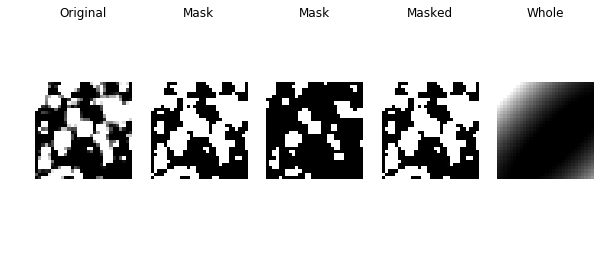

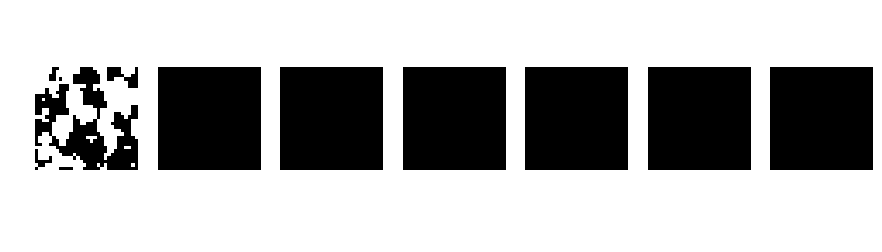

In [176]:
def dump(obj):
   for attr in dir(obj):
       if hasattr( obj, attr ):
           print( "obj.%s = %s" % (attr, getattr(obj, attr)))


from astropy.modeling import models, fitting

reg = target.integrated_postcard[min_i:max_i, min_j:max_j]

int_mask = np.where(reg >= np.median(reg), 1, 0)
int_mask2 = np.where(reg >= np.nanpercentile(reg, 80), 1, 0)
#make_background_mask_max(target, reg, max_factor=0)
reg_masked = np.ma.masked_array(z_old, mask=int_mask)

def build_dict(keys, values):
    dic = {}
    for i, key in enumerate(keys):
#        dic[key] = values[i]
#         if key == u'c1_1' or key == u'c0_2' or key == u'c2_0':
        dic[key] = values[i]
    return dic

def make_model_background(img, model_pix=15):
    ycoord = min(model_pix*2, img.shape[0])
    xcoord = min(model_pix*2, img.shape[1])
    y, x = np.mgrid[:ycoord, :xcoord]
    p_init = models.Polynomial2D(degree=2)
    fit_p = fitting.LinearLSQFitter()
    p = fit_p(p_init, x, y, z=img)

    dic = build_dict(p.param_names, p.parameters)

    model = p(x, y)
    return model, dic

int_model, dic = make_model_background(reg_masked)

def format_arr(arr, sep="\t"):
    return sep.join(str(i) for i in arr)

def get_params(params):
    new_params = ()
    for param in params:
        if param.value == 0:
            try:
                new_params += (param.fixed,)
            except:
                new_params += (param.value,)
        else:
            new_params += (param.value,)
    return new_params
    
def get_2d_roots(params):
    c00, c01, c02, c11, c10, c20 = params
    x_peak = (2 * c02 * c10 - c01 * c11) / (c11 * c11 - 4 * c02 * c20)
    y_peak = (-c10 - 2 * c20 * x_peak) / c11
    return x_peak, y_peak

# c_{00} + c_{01}y + c_{02}y^2 + c_{11}xy + c_{10}x + c_{20}x^2

def make_fixed_background(img, fixed_dic, model_pix=15):
    ycoord = min(model_pix*2, img.shape[0])
    xcoord = min(model_pix*2, img.shape[1])
    y, x = np.mgrid[:ycoord, :xcoord]
    p_init = models.Polynomial2D(degree=2, fixed = dic
#                                  { \
#                                    u'c1_1': -2.3121435104646308\
#                                   , u'c0_0': 57.829088906161921\
#                                   , u'c0_1': 8.1586949707875736\
#                                   , u'c0_2': 1.4224461334073355\
#                                   , u'c1_0': -20.203072124150253\
#                                   , u'c2_0': 1.3098163181773526\
#                                  }
                                )
    fit_p = fitting.LevMarLSQFitter()
    p = fit_p(p_init, x, y, z=img)
        
    params = get_params([p.c0_0, p.c0_1, p.c0_2, p.c1_1, p.c1_0, p.c2_0])

    model = p(x, y)
    
    x2 = x.flatten()
    y2 = y.flatten()
    z2 = img.flatten()

    a = np.array([x2*0+1, y2, y2**2, x2*y2, x2, x2**2]).T
    a = np.array([x2*0+1, y2, x2]).T
    b = img.flatten()

    coeff, r, rank, s = np.linalg.lstsq(a, b)
   
    coeff = np.insert(coeff, [2, 2], [1.4224461334073355, -2.3121435104646308])
    coeff = np.append(coeff, 1.3098163181773526)
    
    print format_arr(params)
    print format_arr(coeff)
    print get_2d_roots(tuple(params))
    print get_2d_roots(tuple(coeff))
    
    return model


first = target.postcard[0][min_i:max_i, min_j:max_j]
first_mask = np.where(first >= np.median(data), 1, 0)
first_masked = np.ma.masked_array(first, mask=first_mask)

new_mod0 = make_fixed_background(first, dic)
new_mod1 = make_fixed_background(target.postcard[1][min_i:max_i, min_j:max_j], dic)
new_mod2 = make_fixed_background(target.postcard[10][min_i:max_i, min_j:max_j], dic)
new_mod3 = make_fixed_background(target.postcard[20][min_i:max_i, min_j:max_j], dic)
new_mod4 = make_fixed_background(target.postcard[30][min_i:max_i, min_j:max_j], dic)
new_mod5 = make_fixed_background(target.postcard[40][min_i:max_i, min_j:max_j], dic)
new_mod6 = make_fixed_background(target.postcard[51][min_i:max_i, min_j:max_j], dic)

fig, axes = plt.subplots(1, 5, figsize=(10, 4), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(reg, vmin=0, vmax=1000, cmap='gray', origin='lower')
ax[0].axis('off')
ax[0].set_title('Original')

ax[1].imshow(int_mask, vmin=0, vmax=1, cmap='gray', origin='lower')
ax[1].axis('off')
ax[1].set_title('Mask')

ax[2].imshow(int_mask2, vmin=0, vmax=1, cmap='gray', origin='lower')
ax[2].axis('off')
ax[2].set_title('Mask')

ax[3].imshow(reg_masked, vmin=0, vmax=1000, cmap='gray', origin='lower')
ax[3].axis('off')
ax[3].set_title('Masked')

ax[4].imshow(int_model, cmap='gray', origin='lower', vmin=0, vmax=1000)
ax[4].axis('off')
ax[4].set_title('Whole')

figs, axess = plt.subplots(1, 7, figsize=(15, 4), sharex=True, sharey=True)
axs = axess.ravel()

axs[0].imshow(first_mask, cmap='gray', origin='lower', vmin=0, vmax=1) 
axs[0].axis('off')

axs[1].imshow(new_mod2, cmap='gray', origin='lower') #, vmin=0, vmax=1000) 
axs[1].axis('off')

axs[2].imshow(new_mod3, cmap='gray', origin='lower', vmin=0, vmax=1000) 
axs[2].axis('off')

axs[3].imshow(new_mod3, cmap='gray', origin='lower', vmin=0, vmax=1000) 
axs[3].axis('off')

axs[4].imshow(new_mod4, cmap='gray', origin='lower', vmin=0, vmax=1000) 
axs[4].axis('off')

axs[5].imshow(new_mod5, cmap='gray', origin='lower', vmin=0, vmax=1000) 
axs[5].axis('off')

axs[6].imshow(new_mod6, cmap='gray', origin='lower', vmin=0, vmax=1000) 
axs[6].axis('off')

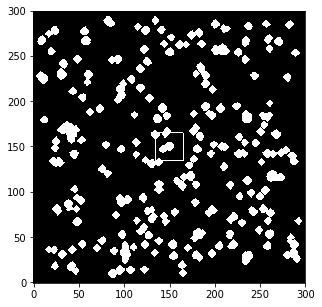

In [24]:
hey_mask = np.where(target.targets != 0, 1, 0)

hey_mask[min_i,min_j:max_j] = 1
hey_mask[max_i,min_j:max_j] = 1
hey_mask[min_i:max_i,min_j] = 1
hey_mask[min_i:max_i,max_j] = 1

plt.imshow(hey_mask, vmin=0, vmax=1, cmap='gray', origin='lower')

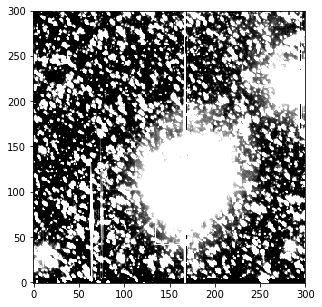

In [14]:
old_int[min_i,min_j:max_j] = maximum
old_int[max_i,min_j:max_j] = maximum
old_int[min_i:max_i,min_j] = maximum
old_int[min_i:max_i,max_j] = maximum
plt.imshow(old_int, vmin=0, vmax=1000, cmap='gray', origin='lower')

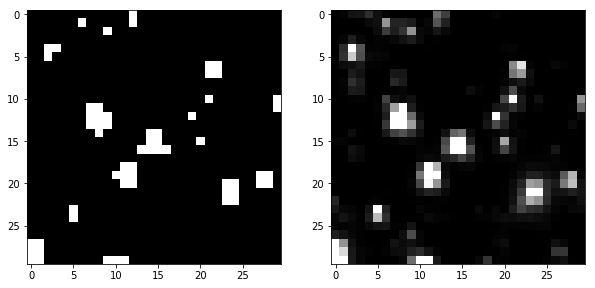

In [28]:
maximum = np.max(post[np.nonzero(post)])
minimum = 0

region = target.postcard[0]
zold = region[min_i:max_i, min_j:max_j]

mask_2 = np.where(zold >= np.max(zold)*0.01, 1, 0)

plt.figure(12345)
plt.subplot(1, 2, 1)
plt.imshow(mask_2, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(zold, vmin=0, vmax=1000, cmap='gray')

Text(0.5,1,u'Mask')

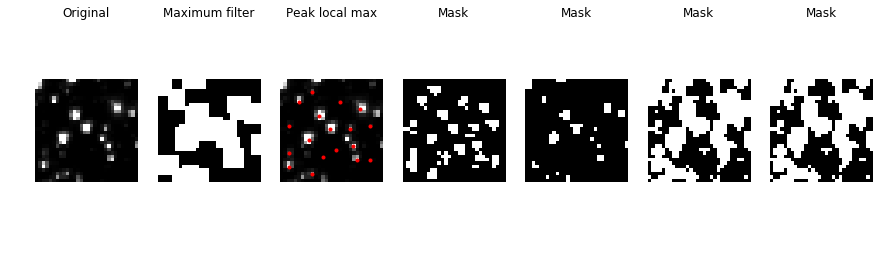

In [38]:
data = first

def get_region(arr):
    minimum = np.median(arr)
    return np.where(arr > minimum, 1, 0)

def build_mask_layer(img, coord, pix):
    i, j = coord
    region = img[i-pix:i+pix, j-pix:j+pix]
    mask_region = get_region(region)
    new = np.zeros_like(img)
    new[i-pix:i+pix, j-pix:j+pix] = mask_region
    return new

from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import img_as_float

im = img_as_float(data)

# image_max is the dilation of im with a 20*20 structuring element
# It is used within peak_local_max function
image_max = ndi.maximum_filter(im, size=5, mode='constant')
img_max_mask = get_region(image_max)

# Comparison between image_max and im to find the coordinates of local maxima
coordinates = peak_local_max(im, min_distance=2)

ult_mask = np.zeros_like(im)
for coord in coordinates:
    coord_tuple = tuple(coord)
    ult_mask += build_mask_layer(im, coord_tuple, 2)
ult_mask = np.where(ult_mask > 0, 1, 0)

max_mask = np.where(data >= 0.5*np.average(data), 1, 0)
max_mask = np.where(data >= 0.01*np.max(data), 1, 0)

maximum = np.max(data[np.nonzero(data)])
minimum = np.min(data[np.nonzero(data)])

med_mask = np.where(data >= np.median(data[np.where(data >= minimum)]), 1, 0)
med_mask_relax = np.where(data >= np.median(data), 1, 0)

# display results
fig, axes = plt.subplots(1, 7, figsize=(15, 4), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(im, vmin=0, vmax=1000, cmap='gray', origin='lower')
ax[0].axis('off')
ax[0].set_title('Original')

ax[1].imshow(img_max_mask, vmin=0, vmax=1, cmap='gray', origin='lower')
ax[1].axis('off')
ax[1].set_title('Maximum filter')

ax[2].imshow(im, vmin=0, vmax=1000, cmap='gray', origin='lower')
ax[2].autoscale(False)
ax[2].plot(coordinates[:, 1], coordinates[:, 0], 'r.')
ax[2].axis('off')
ax[2].set_title('Peak local max')

ax[3].imshow(ult_mask, vmin=0, vmax=1, cmap='gray', origin='lower')
ax[3].axis('off')
ax[3].set_title('Mask')

ax[4].imshow(max_mask, vmin=0, vmax=1, cmap='gray', origin='lower')
ax[4].axis('off')
ax[4].set_title('Mask')

ax[5].imshow(med_mask, vmin=0, vmax=1, cmap='gray', origin='lower')
ax[5].axis('off')
ax[5].set_title('Mask')

ax[6].imshow(med_mask_relax, vmin=0, vmax=1, cmap='gray', origin='lower')
ax[6].axis('off')
ax[6].set_title('Mask')

In [76]:
a = np.arange(2, 18)
print -np.percentile(a, 0)
print 2 + -np.percentile(a, 0)

-2.0
0.0


In [148]:
location = "./"
import os
os.sys.path.append(location)
from parse_plot import *

In [126]:
data = zold

from astropy.stats import sigma_clipped_stats
from photutils import find_peaks
mean, median, std = sigma_clipped_stats(zold, sigma=3.0)
threshold = median + (10.0 * std)
tbl = find_peaks(data, threshold, box_size=5)

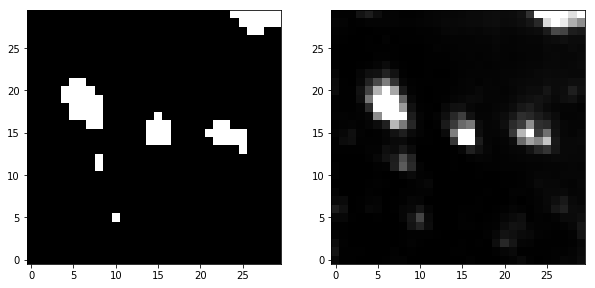

In [130]:
pixels = 3

#for i, coord in enumerate(zip(tbl['x_peak'], tbl['y_peak'])):
#    region = 

mask_3 = np.where(zold >= np.max(zold)*0.01, 1, 0)

plt.figure(12345)
plt.subplot(1, 2, 1)
plt.imshow(mask_3, cmap='gray', origin='lower')
plt.subplot(1, 2, 2)
plt.imshow(zold, vmin=0, vmax=1000, cmap='gray', origin='lower')

(0, 29)

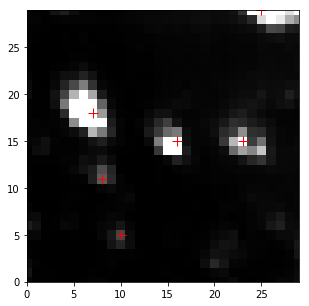

In [128]:
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(data, cmap='gray', origin='lower', vmin=0, vmax=1000) #norm=norm, 
plt.plot(tbl['x_peak'], tbl['y_peak'], ls='none', color='red', marker='+', ms=10, lw=1.5)
plt.xlim(0, data.shape[1]-1)
plt.ylim(0, data.shape[0]-1)


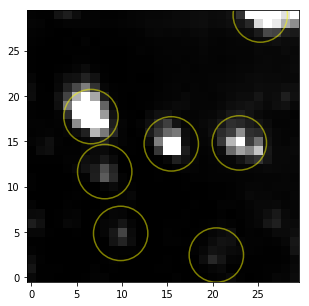

In [129]:
from photutils import DAOStarFinder
daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)    
sources = daofind(data - median)    
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import CircularAperture
positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=3)
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(data, cmap='gray', origin='lower',  vmin=0, vmax=1000) #norm=norm
apertures.plot(color='yellow', lw=1.5, alpha=0.5)

# REAL F3 STUFF

In [3]:
target = photometry.star(8462852)

In [4]:
target.make_postcard()

The step above takes all the FFIs and locates a small region centered on the target. It takes three optional arguments. npix is the size of the square postcard region. shape=(1070,1132) is the size of the FFIs, which can be changed if you're adapting the code to something other than Kepler FFIs (such as TESS data). buffer_size avoids the outermost pixels on the detector, so that each target should have its entire PSF on the detector.

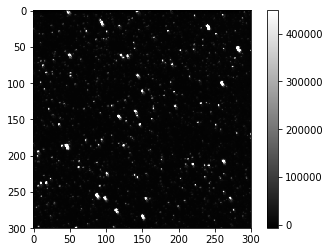

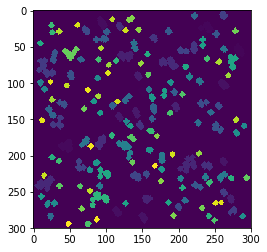

TypeError: slice indices must be integers or None or have an __index__ method

In [5]:
target.find_other_sources(plot_flag=True)

This step will draw apertures around the target star and up to ntargets additional targets on the same postcard.
It will then remove apertures that touch the border of the postcard and combine apertures that touch into one target,
treating those stars as a single object for the rest of the procedure.

The "plot_flag" argument will show a stacked plot of the postcard images, then a plot of all apertures for all targets, then a plot of the default aperture for the primary target, and finally data for the entire postcard, with apertures for all targets highlighted over the data.

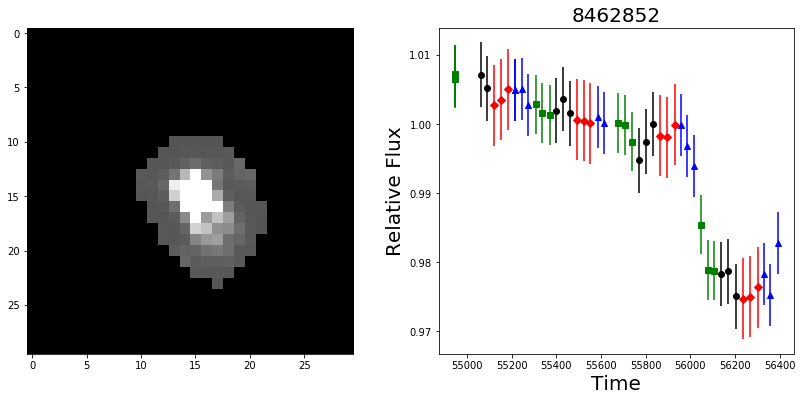

In [6]:
target.adjust_aperture(ignore_bright=0)

Perhaps the initial aperture isn't appropriate, because it contians another star or doesn't capture the entire PSF, for example. This routine will enable you to change the aperture for the target star. It will open up a window showing the aperture (and underlying data) and the current light curve for the target star. By clicking on individual pixels, you can include or exclude them from the aperture. Closing the panel will then cause the photometry pipeline to re-run, and you can see how the light curve has changed from including/excluding those pixels. This will repeat until the image is closed without any changes to the aperture.

Clicking on the zeroth row/column (on the top or left) will cause all pixels in that column/row (respectively) to be turned off.

Re-running find_other_sources will restart this procedure, giving you back the default aperture. (Note: this routine won't work in a Jupyter notebook, but will from the command line or in a script.)

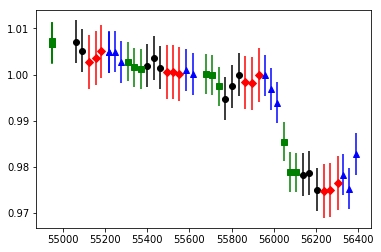

In [9]:
fmt = ['ko', 'rD', 'b^', 'gs']

for i in range(4):
    g = np.where(target.qs == i)[0]
    plt.errorbar(target.times[g], target.obs_flux[g], yerr=target.flux_uncert[i], fmt=fmt[i])

The error bars are overestimated in this case---they represent the residuals to a linear fit to the data, which is clearly inappropriate for this star. The colors/shapes represent different orientations of the spacecraft as it rotates to keep its solar panels aligned with the Sun.

In [10]:
target.data_for_target(ignore_bright=0)

This calculates photometry without the aperture varying step, just using whatever aperture is currently defined (where target.targets == 1). target.targets == 0 is the background, and all other integers correspond to different targets.

In [11]:
target.calc_centroids()

Measures the centroid shift.

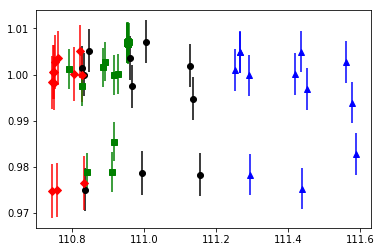

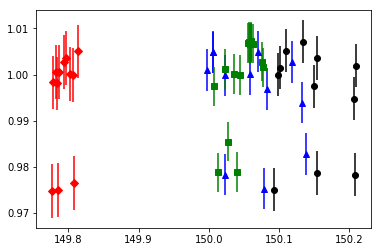

In [13]:
for i in range(4):
    g = np.where(target.qs == i)[0]
    plt.errorbar(target.cm[g,0], target.obs_flux[g], yerr=target.flux_uncert[i], fmt=fmt[i])
    
plt.show()
    
for i in range(4):
    g = np.where(target.qs == i)[0]
    plt.errorbar(target.cm[g,1], target.obs_flux[g], yerr=target.flux_uncert[i], fmt=fmt[i])

No obvious correlation with the large dimming here!

In [14]:
target.define_spotsignal()

This roughly estimates with the flux "should" be at the FFI times based on the starspot signal at the last observation before the FFIs by computing the flux at that last observation (1 hour before the FFI) relative to the median flux in that quarter of observations. Useful for making sure you're not being confused with aliasing.

We then can use the method in the appendix of our paper to model the uncertainties.

In [15]:
target.model_uncert()

Text(0,0.5,'Normalized Flux')

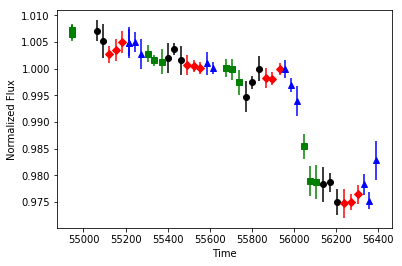

In [16]:
for i in range(4):
    g = np.where(target.qs == i)[0]
    plt.errorbar(target.times[g], target.obs_flux[g], yerr=target.target_uncert[g], fmt=fmt[i])
plt.xlabel('Time')
plt.ylabel('Normalized Flux')

Looks reasonable!